In [5]:
# Import other modules
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Import the scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [8]:
# Add data to dataframe
df = pd.read_csv("REMS_Mars_Dataset.csv")
df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny


2.1 Cleaning the data
There are a number of columns that must be cleaned before they can be analyzed, predominately the earth_date_time column which needs to have the date string pulled (it does not contain time), and then converted to datetime dtype. This value will be added to a new datatime so as to not delete potentially relevant data called shaved_earth_date_time. Another good thing to do here is convert all string values that show no data, Value not available as np.nan to help with future cleaning tasks.

In [9]:
df["shaved_earth_date_time"] = pd.to_datetime(df["earth_date_time"].str.replace('Earth, ','').str.replace(' UTC',''),format='%Y-%m-%d')

In [11]:
import numpy as np

In [12]:
df = df.replace("Value not available",np.nan)

In [13]:
df["humidity(%)"].unique(),df["UV_Radiation"].unique(),df["wind_speed(m/h)"].unique(),df["weather"].unique()

(array([nan]),
 array(['moderate', 'low', 'high', 'very_high', nan], dtype=object),
 array([nan]),
 array(['Sunny', nan], dtype=object))

**Attributes to compare**
<br>
earth_date_time => shaved_earth_date_time<br>
max_ground_temp(°C) <br>
min_ground_temp(°C)<br>
max_air_temp(°C)<br>
min_air_temp(°C)<br>
mean_pressure(Pa)<br>
sunrise<br>
sunset<br>
UV_Radiation<br>

In [14]:
relevant_df = df[[
    'shaved_earth_date_time',
    'max_ground_temp(°C)',
    'min_ground_temp(°C)',
    'max_air_temp(°C)',
    'min_air_temp(°C)',
    'mean_pressure(Pa)',
    'sunrise',
    'sunset',
    'UV_Radiation'
]]

In [15]:
relevant_df = relevant_df.astype({
    'max_ground_temp(°C)':float,
    'min_ground_temp(°C)':float,
    'max_air_temp(°C)':float,
    'min_air_temp(°C)':float,
    'mean_pressure(Pa)':float
})

In [16]:
relevant_df['sunrise'] = pd.to_datetime(relevant_df['sunrise'],format="%H:%M")
relevant_df['sunset'] = pd.to_datetime(relevant_df['sunset'],format="%H:%M")

In [17]:
# create a priority map of the values for UV_Radiation
mapping = {
    'low':0.0,
    'moderate':1.0,
    'high':2.0,
    'very_high':3.0,
}
relevant_df['UV_Radiation_map'] = (relevant_df['UV_Radiation'].map(mapping)).astype('float')

In [18]:
relevant_df = relevant_df.drop('UV_Radiation',axis=1)


In [19]:
relevant_df.dtypes

shaved_earth_date_time    datetime64[ns]
max_ground_temp(°C)              float64
min_ground_temp(°C)              float64
max_air_temp(°C)                 float64
min_air_temp(°C)                 float64
mean_pressure(Pa)                float64
sunrise                   datetime64[ns]
sunset                    datetime64[ns]
UV_Radiation_map                 float64
dtype: object

2.2 Compare attributes¶
Before we dig deeper into specific comparisions, we should get an overarching view of the data as a whole.

In [20]:
relevant_df.describe()

,shaved_earth_date_time,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation_map
count,3197,3169.000000,3169.000000,3168.000000,3168.000000,3170.000000,3197,3197,3170.000000
mean,2017-05-06 12:15:05.348764416,-13.209214,-75.016409,2.010732,-80.317551,828.792429,1900-01-01 05:59:34.644979456,1900-01-01 17:57:44.798248448,1.579180
min,2012-08-07 00:00:00,-67.000000,-100.000000,-61.000000,-136.000000,702.000000,1900-01-01 05:18:00,1900-01-01 17:20:00,0.000000
25%,2015-01-04 00:00:00,-23.000000,-79.000000,-6.000000,-86.000000,785.000000,1900-01-01 05:33:00,1900-01-01 17:28:00,1.000000
50%,2017-04-28 00:00:00,-12.000000,-75.000000,3.000000,-80.000000,843.000000,1900-01-01 05:56:00,1900-01-01 17:47:00,2.000000
75%,2019-09-23 00:00:00,-4.000000,-71.000000,10.000000,-75.000000,873.000000,1900-01-01 06:27:00,1900-01-01 18:29:00,2.000000
max,2022-01-26 00:00:00,11.000000,-52.000000,24.000000,-8.000000,925.000000,1900-01-01 06:47:00,1900-01-01 18:55:00,3.000000
std,NaN,10.493719,5.529282,9.401705,8.845239,57.119649,NaN,NaN,0.689969


In [21]:
relevant_df.isnull().sum()

shaved_earth_date_time     0
max_ground_temp(°C)       28
min_ground_temp(°C)       28
max_air_temp(°C)          29
min_air_temp(°C)          29
mean_pressure(Pa)         27
sunrise                    0
sunset                     0
UV_Radiation_map          27
dtype: int64

In [22]:
relevant_df = relevant_df.dropna()

Below will be the function definition that will take in an axes subplot and graph a trendline and provide an R² value.

This function use the np.polyfit() function to fit the linear regression model, then manually calculate out the R² value:

R
2
=
1
−
S
S
r
e
s
S
S
t
o
t
 
Where:

S
S
r
e
s
  is the residual sum of squares:  
∑
(
y
a
c
t
u
a
l
−
y
p
r
e
d
i
c
t
e
d
)
2
 
S
S
t
o
t
  is the total sum of squares:  
∑
(
y
a
c
t
u
a
l
−
¯
y
)
2
 , where  
¯
y
  is the mean of  
y
 
Considerations:

polynomial degrees greater than 1 need rework

In [23]:
# define function to create R² trendlines for axes plots
def plot_trendline(ax,x,y,n=1):
    
    coeffs = np.polyfit(x,y,n)
    poly_eq = np.poly1d(coeffs)
    y_pred = poly_eq(x)
    ax.plot(x,y_pred,color='red',linewidth=2)
    
    # calculate the R² value and set the title to it
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    ax.set_title(f'R² = {r_squared:.2f}')

Then, we will graph all the possible comparisons as small graphs and see which data looks like we can dig more into.

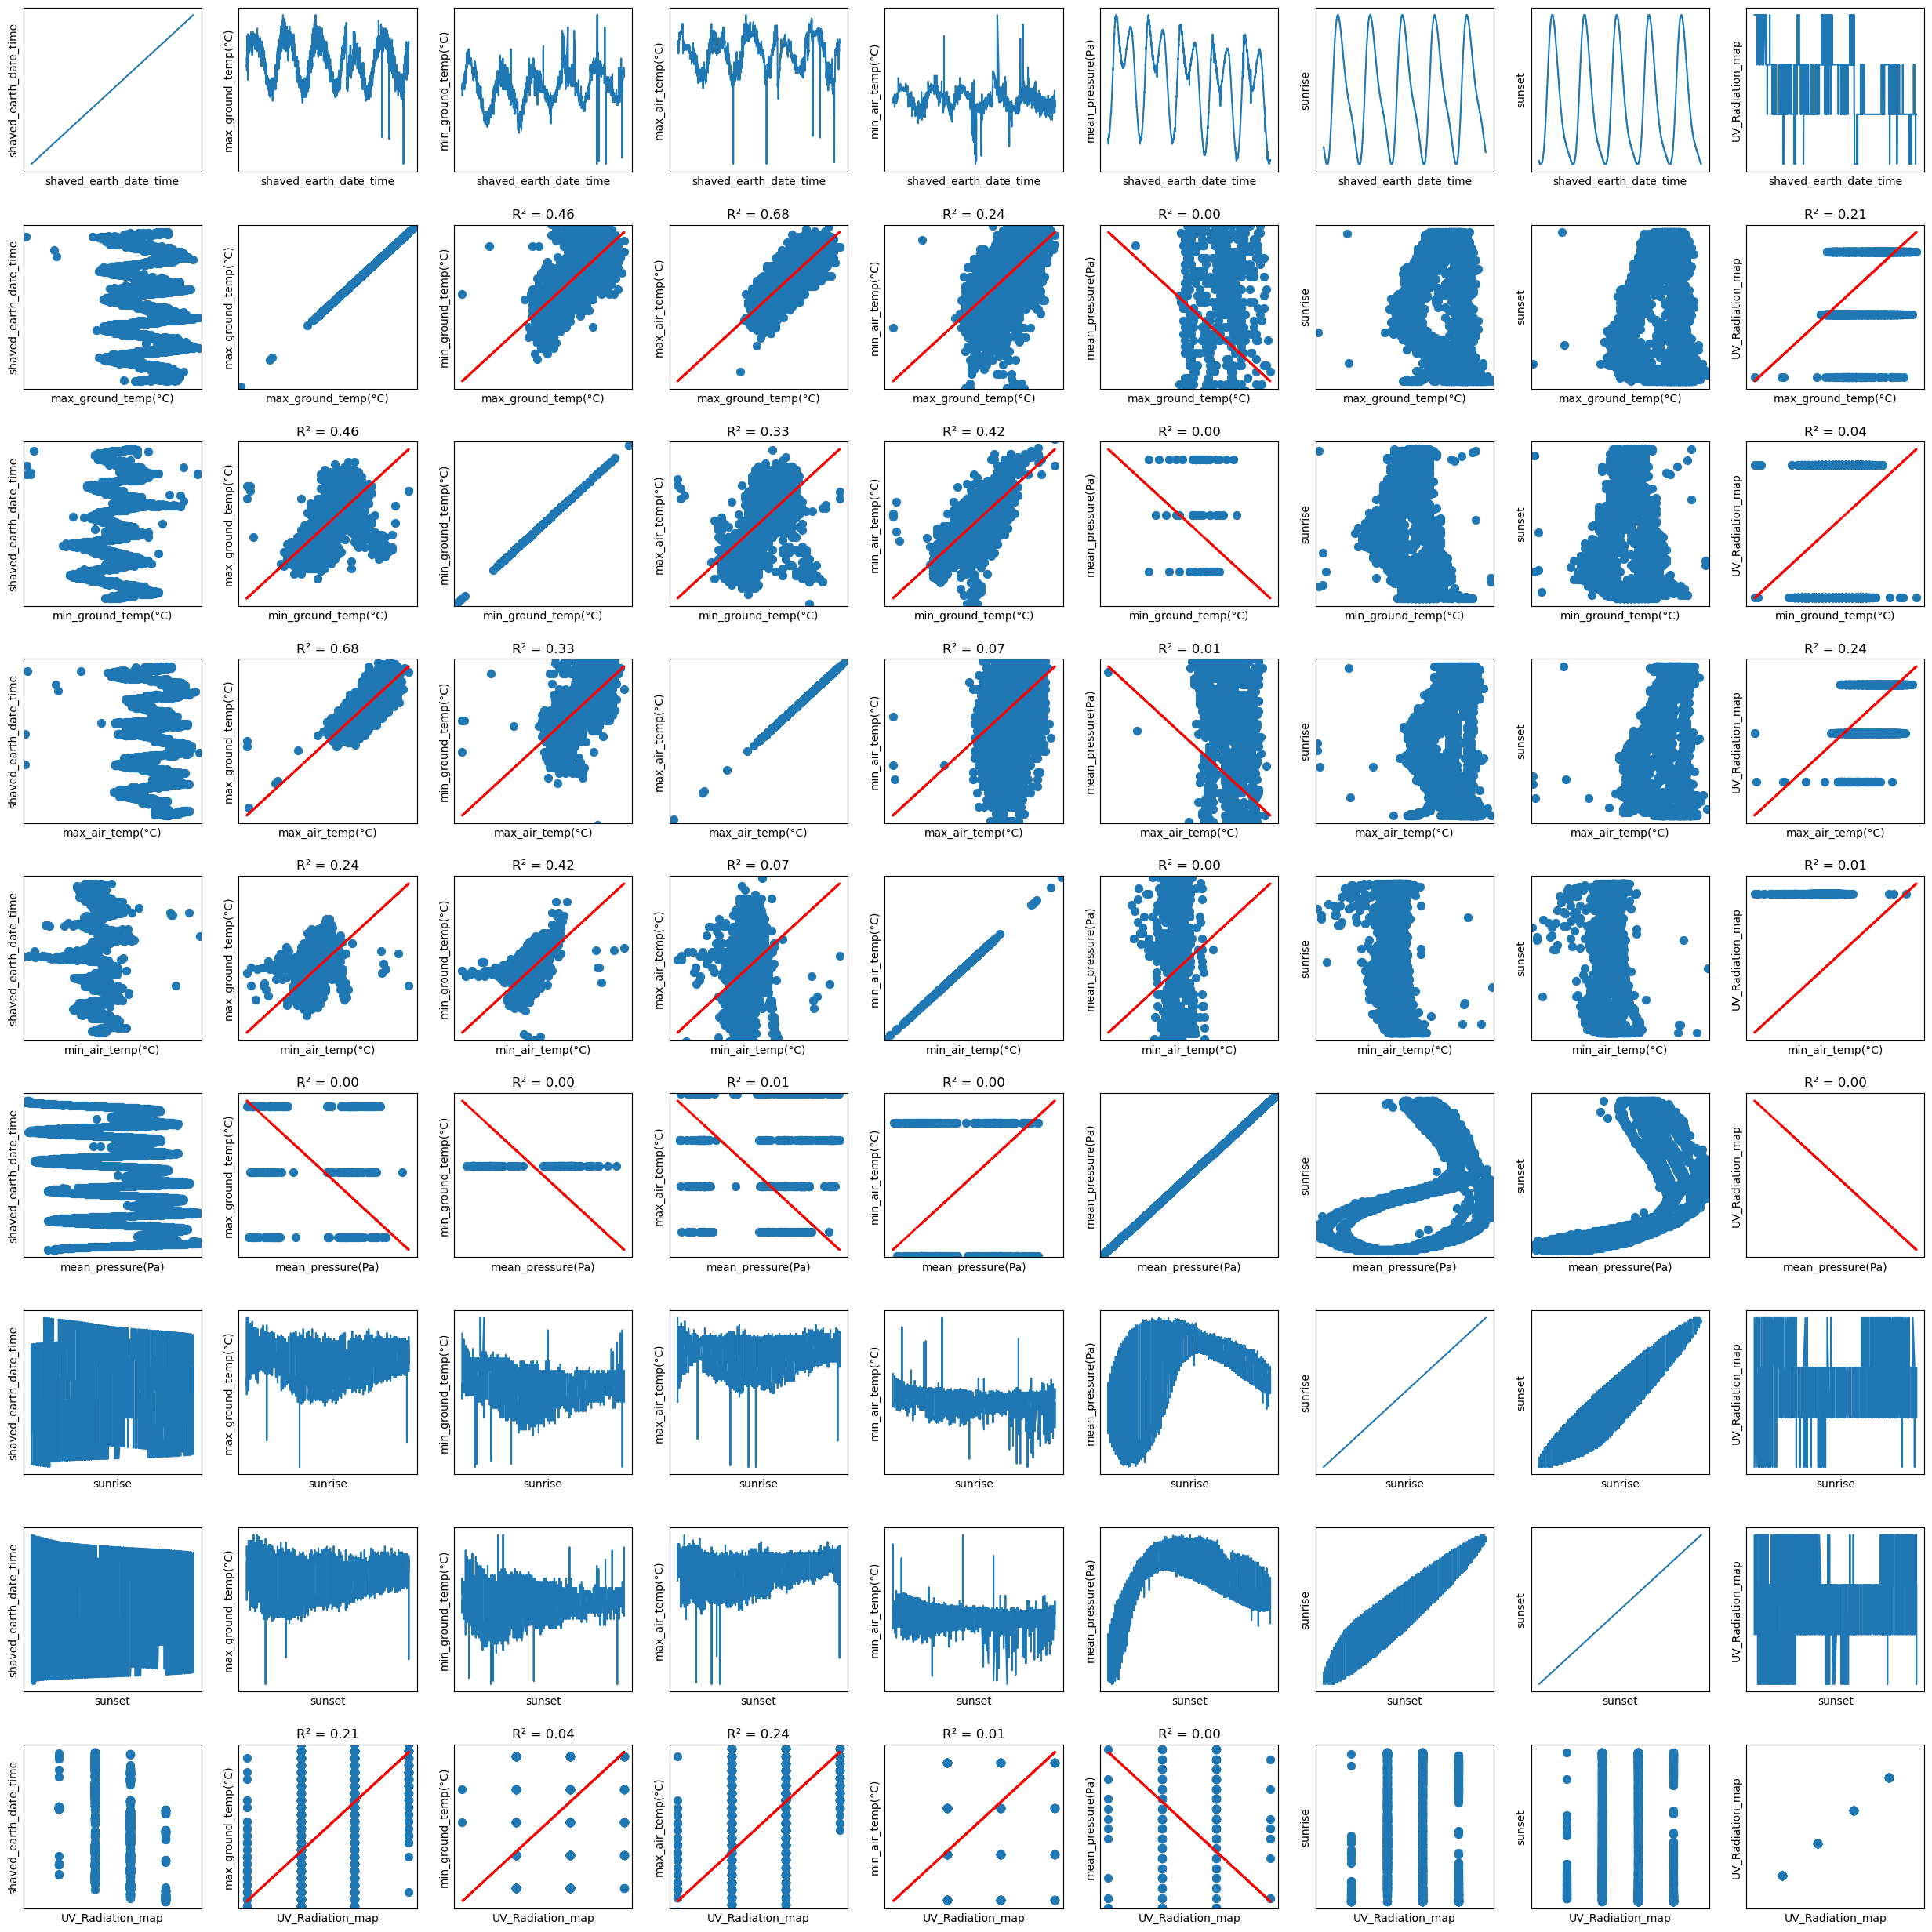

In [25]:
# create the subplots
fig,axes = plt.subplots(nrows=len(relevant_df.columns),ncols=len(relevant_df.columns),figsize=(25,25))

# iterate through the subplots and customziations automatically
for i,column_x in enumerate(relevant_df.columns):
    for j,column_y in enumerate(relevant_df.columns):
        
        # high level graph generation
        if relevant_df[column_x].dtype == 'datetime64[ns]':
            relevant_df = relevant_df.sort_values(by=column_x)
            axes[i][j].plot(relevant_df[column_x],relevant_df[column_y])
        else:
            axes[i][j].scatter(relevant_df[column_x],relevant_df[column_y],s=50)
            
            # set the limits as scatter is not scalling the axis correctly
            axes[i][j].set_xlim([relevant_df[column_x].min()-1,relevant_df[column_x].max()+1])
            if relevant_df[column_y].dtype != 'datetime64[ns]': # avoid scaling the y axis for datetime values
                axes[i][j].set_ylim([relevant_df[column_y].min()-1,relevant_df[column_y].max()+1])
            
            # generate a trendline that spits out the R² value
            if i != j and not relevant_df[column_x].dtype == 'datetime64[ns]' and not relevant_df[column_y].dtype == 'datetime64[ns]':
                plot_trendline(axes[i][j],relevant_df[column_x],relevant_df[column_y])
        
        # customizations in subplot graphs
        axes[i][j].set_xlabel(column_x)
        axes[i][j].set_ylabel(column_y)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].relim()
        axes[i][j].autoscale()

plt.tight_layout(pad=2.0)

In [26]:
# Although the above is very flashy, and possibly a bit off, 
# I realized I could make a correlation matrix in a much easier way
relevant_df.corr(numeric_only=True)

,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),UV_Radiation_map
max_ground_temp(°C),1.000000,0.675160,0.822246,0.489733,-0.055522,0.463514
min_ground_temp(°C),0.675160,1.000000,0.570791,0.646849,-0.005391,0.188318
max_air_temp(°C),0.822246,0.570791,1.000000,0.268380,-0.088271,0.491036
min_air_temp(°C),0.489733,0.646849,0.268380,1.000000,0.032279,0.084616
mean_pressure(Pa),-0.055522,-0.005391,-0.088271,0.032279,1.000000,-0.060563
UV_Radiation_map,0.463514,0.188318,0.491036,0.084616,-0.060563,1.000000


In [27]:
relevant_df.corr()

,shaved_earth_date_time,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation_map
shaved_earth_date_time,1.000000,-0.180286,0.101060,-0.035611,-0.088602,-0.239521,0.043786,-0.013954,-0.425005
max_ground_temp(°C),-0.180286,1.000000,0.675160,0.822246,0.489733,-0.055522,-0.108943,0.193777,0.463514
min_ground_temp(°C),0.101060,0.675160,1.000000,0.570791,0.646849,-0.005391,-0.116054,0.181470,0.188318
max_air_temp(°C),-0.035611,0.822246,0.570791,1.000000,0.268380,-0.088271,-0.037255,0.221900,0.491036
min_air_temp(°C),-0.088602,0.489733,0.646849,0.268380,1.000000,0.032279,-0.181209,0.057592,0.084616
mean_pressure(Pa),-0.239521,-0.055522,-0.005391,-0.088271,0.032279,1.000000,0.463749,0.526772,-0.060563
sunrise,0.043786,-0.108943,-0.116054,-0.037255,-0.181209,0.463749,1.000000,0.932317,-0.027490
sunset,-0.013954,0.193777,0.181470,0.221900,0.057592,0.526772,0.932317,1.000000,0.081902
UV_Radiation_map,-0.425005,0.463514,0.188318,0.491036,0.084616,-0.060563,-0.027490,0.081902,1.000000


Based on the correlation matrices, it appears that there are a couple of feature pairings that works well together:<br>
<br>
sunset correlates well with sunrise [high]<br>
max_air_temp(C) correlates well with max_ground_temp(C) [mid-high]<br>
min_air_temp(C) correlates well with min_ground_temp(C) [mid]<br>
min_air_temp(C) correlates well with max_ground_temp(C) [mid]<br>
max_air_temp(C) correlates well with min_ground_temp(C) [mid]<br>

/Users/shashikumarezhil/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


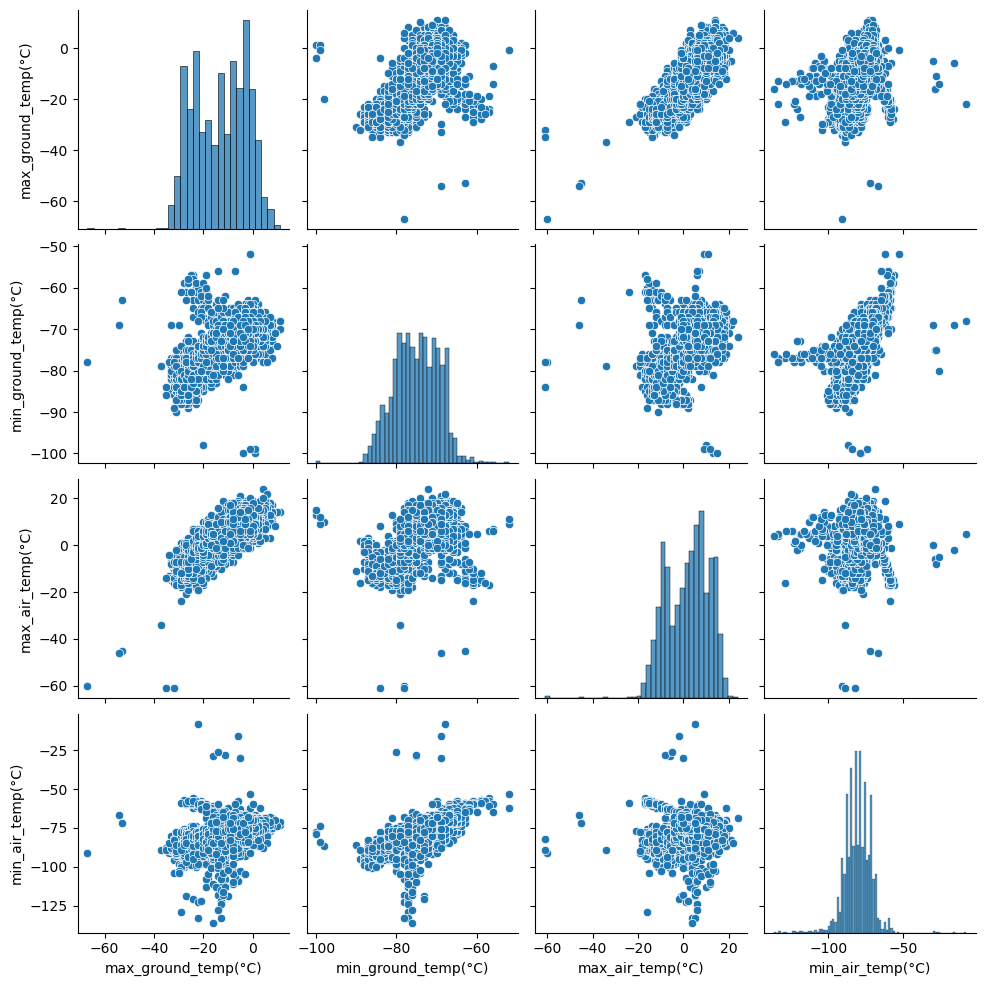

In [28]:
import seaborn as sns

# pair plotting the air and ground temperatures
sns.pairplot(
    relevant_df,
    x_vars=['max_ground_temp(°C)','min_ground_temp(°C)','max_air_temp(°C)','min_air_temp(°C)'],
    y_vars=['max_ground_temp(°C)','min_ground_temp(°C)','max_air_temp(°C)','min_air_temp(°C)']
)
